### Introduction :

We'll work with the VGG16 architecture, using weights that have been trained in ImageNet. We'll walk through three different ways to use its architecture and fine-tune it to be used for classification of dense vs. fatty breast tissue on mammogram images (Betweem Dense, and fatty ).

The three scenarios for you to try are the following:

* Freeze all layers except for the final convolutional layer of VGG16.
* Freeze all layers except the final convolutional layer of VGG16, and add several dense (fully connected) layers.
* Freeze all layers except the final convolutional layer of VGG16, and add several dense (fully connected) layers with dropout.

In [1]:
import numpy as np
import pandas as pd
import os
import glob as gb
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

## Data Preprocessing for the model

In [2]:
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

In [3]:
valid_df.head()

,img_path,class
0,mdb293.pgm.png,fatty
1,mdb297.pgm.png,fatty
2,mdb299.pgm.png,fatty
3,mdb315.pgm.png,dense
4,mdb317.pgm.png,dense


In [4]:
# We get the image size from the input layer data of VGG16 Architecture.
IMG_SIZE = (224, 224)

In [5]:
train_idg = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = False,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
    shear_range = 0.1,
    rotation_range = 20,
    zoom_range = 0.1
)

train_gen = train_idg.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'img_path',
    y_col = 'class',
    class_mode = 'binary',
    batch_size = 3,
    target_size = IMG_SIZE
)

Found 20 validated image filenames belonging to 2 classes.


In [6]:
val_idg = ImageDataGenerator(
    rescale = 1./255.0
)

val_gen = val_idg.flow_from_dataframe(
    dataframe = valid_df,
    x_col = 'img_path',
    y_col = 'class',
    class_mode = 'binary',
    batch_size = 3,
    target_size = IMG_SIZE
)

Found 6 validated image filenames belonging to 2 classes.


In [7]:
# Pull a single large batch of random validation data for testing after each epoch
testx, testy = val_gen.next()

In [8]:
testx.shape

(3, 224, 224, 3)

## Model building & Fine Tuning.

#### 1.Freeze all layers except for the final convolutional layer of VGG16.

In [9]:
model = VGG16()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
# transfer layer is the last layer before the flatten layer
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [11]:
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [12]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [13]:
new_model = Sequential()
# The pre-trained architecture
new_model.add(vgg_model)
# Flatten the output of the VGG16 model because it is from a convolutional layer.
new_model.add(Flatten())
#The output layer
new_model.add(Dense(1, activation = 'sigmoid'))

In [14]:
new_model.compile(
    optimizer= Adam(learning_rate= 0.0001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'])

In [15]:
new_model.fit(train_gen,
              validation_data = (testx, testy), 
              epochs = 20)

Epoch 1/20
7/7 [==============================] - 3s 373ms/step - loss: 0.7186 - binary_accuracy: 0.4000 - val_loss: 0.4984 - val_binary_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 2s 342ms/step - loss: 0.6723 - binary_accuracy: 0.5500 - val_loss: 0.3984 - val_binary_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 2s 344ms/step - loss: 0.5103 - binary_accuracy: 0.8000 - val_loss: 0.3777 - val_binary_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 3s 423ms/step - loss: 0.4189 - binary_accuracy: 0.8500 - val_loss: 0.3537 - val_binary_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 4s 552ms/step - loss: 0.3646 - binary_accuracy: 0.9500 - val_loss: 0.2752 - val_binary_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 4s 530ms/step - loss: 0.2750 - binary_accuracy: 0.9500 - val_loss: 0.2196 - val_binary_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 4s 518ms/step - loss: 0.21

#### 2.Freeze all layers except for the final convolutional layer of VGG16 + adding a few more dense layers:

In [16]:
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())

new_model.add(Dense(1024, activation = 'relu'))
new_model.add(Dense(512, activation = 'relu'))
new_model.add(Dense(1, activation = 'sigmoid'))

In [17]:
new_model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"]
)

In [18]:
new_model.fit(
    train_gen,
    validation_data = (testx,testy),
    epochs = 5
)

Epoch 1/5
7/7 [==============================] - 4s 458ms/step - loss: 0.8531 - binary_accuracy: 0.6000 - val_loss: 0.2194 - val_binary_accuracy: 1.0000
Epoch 2/5
7/7 [==============================] - 3s 435ms/step - loss: 0.3908 - binary_accuracy: 0.8500 - val_loss: 0.1629 - val_binary_accuracy: 1.0000
Epoch 3/5
7/7 [==============================] - 3s 457ms/step - loss: 0.2712 - binary_accuracy: 0.9000 - val_loss: 0.0477 - val_binary_accuracy: 1.0000
Epoch 4/5
7/7 [==============================] - 4s 518ms/step - loss: 0.2124 - binary_accuracy: 0.9000 - val_loss: 0.0510 - val_binary_accuracy: 1.0000
Epoch 5/5
7/7 [==============================] - 4s 604ms/step - loss: 0.1218 - binary_accuracy: 0.9500 - val_loss: 0.0035 - val_binary_accuracy: 1.0000


#### 3.Freeze all layers except for the final convolutional layer of VGG16 + adding a few more dense layers and droupout layers:

In [19]:
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())

new_model.add(Dense(1024, activation = 'relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation = 'relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(256, activation = 'relu'))
new_model.add(Dense(1, activation = 'sigmoid'))

In [20]:
new_model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = "binary_crossentropy",
    metrics = ["binary_accuracy"]
)

In [21]:
history = new_model.fit(
    train_gen,
    validation_data = (testx,testy),
    epochs = 20
)

Epoch 1/20
7/7 [==============================] - 4s 460ms/step - loss: 0.8339 - binary_accuracy: 0.5000 - val_loss: 0.3689 - val_binary_accuracy: 1.0000
Epoch 2/20
7/7 [==============================] - 3s 442ms/step - loss: 0.4766 - binary_accuracy: 0.6500 - val_loss: 0.3969 - val_binary_accuracy: 1.0000
Epoch 3/20
7/7 [==============================] - 3s 451ms/step - loss: 0.7421 - binary_accuracy: 0.6500 - val_loss: 0.3013 - val_binary_accuracy: 1.0000
Epoch 4/20
7/7 [==============================] - 4s 518ms/step - loss: 0.8435 - binary_accuracy: 0.6500 - val_loss: 0.0967 - val_binary_accuracy: 1.0000
Epoch 5/20
7/7 [==============================] - 5s 644ms/step - loss: 0.4804 - binary_accuracy: 0.7500 - val_loss: 0.1070 - val_binary_accuracy: 1.0000
Epoch 6/20
7/7 [==============================] - 4s 630ms/step - loss: 0.3663 - binary_accuracy: 0.8500 - val_loss: 0.0548 - val_binary_accuracy: 1.0000
Epoch 7/20
7/7 [==============================] - 4s 598ms/step - loss: 0.30

In [22]:
def plot_loss(history):
    plt.plot( history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch ")
    plt.ylabel("Loss")
    plt.legend()

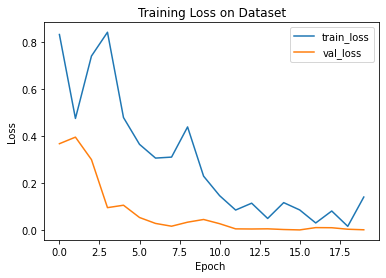

In [23]:
plot_loss(history)

In [24]:
def plot_acc(history):
    plt.plot( history.history["binary_accuracy"], label="train_acc")
    plt.plot(history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch ")
    plt.ylabel("Accuracy")
    plt.legend()
    

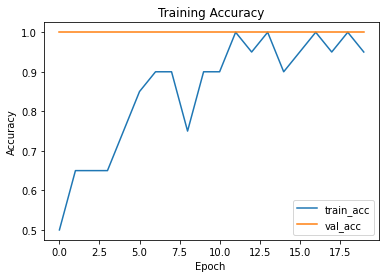

In [25]:
plot_acc(history)